In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as T
import copy
from tqdm import tqdm
from collections import Counter

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Dataset
Load dataset

In [4]:
train_images = np.load('/content/gdrive/MyDrive/COMP448/dermamnist_128/train_images.npy')
train_labels = np.load('/content/gdrive/MyDrive/COMP448/dermamnist_128/train_labels.npy')

val_images = np.load('/content/gdrive/MyDrive/COMP448/dermamnist_128/val_images.npy')
val_labels = np.load('/content/gdrive/MyDrive/COMP448//dermamnist_128/val_labels.npy')

test_images = np.load('/content/gdrive/MyDrive/COMP448/dermamnist_128/test_images.npy')
test_labels = np.load('/content/gdrive/MyDrive/COMP448/dermamnist_128/test_labels.npy')

Check shape of your data

In [5]:
print('Train images size:', train_images.shape)
print('Train labels size:', train_labels.shape)
print('')
print('Validation images size:',val_images.shape)
print('Validation images size:',val_labels.shape)
print('')
print('Test images size:',test_images.shape)
print('Test images size:',test_labels.shape)

Train images size: (7007, 128, 128, 3)
Train labels size: (7007, 1)

Validation images size: (1003, 128, 128, 3)
Validation images size: (1003, 1)

Test images size: (2005, 128, 128, 3)
Test images size: (2005, 1)


**Classes**  
0 : akiec, Actinic keratoses and intraepithelial carcinoma / Bowen's disease  
1 : bcc, basal cell carcinoma (bcc)  
2 : bkl, benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses)   
3 : df, dermatofibroma (df)  
4 : nv, melanocytic nevi  
5 : vasc, vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage)  
6 : mel, melanoma  

In [6]:
classDict = {0 : 'akiec',
1 : 'bcc',
2 : 'bkl',
3 : 'df',
4 : 'nv',
5 : 'vasc',
6 : 'mel'}

### Visualize Random Samples

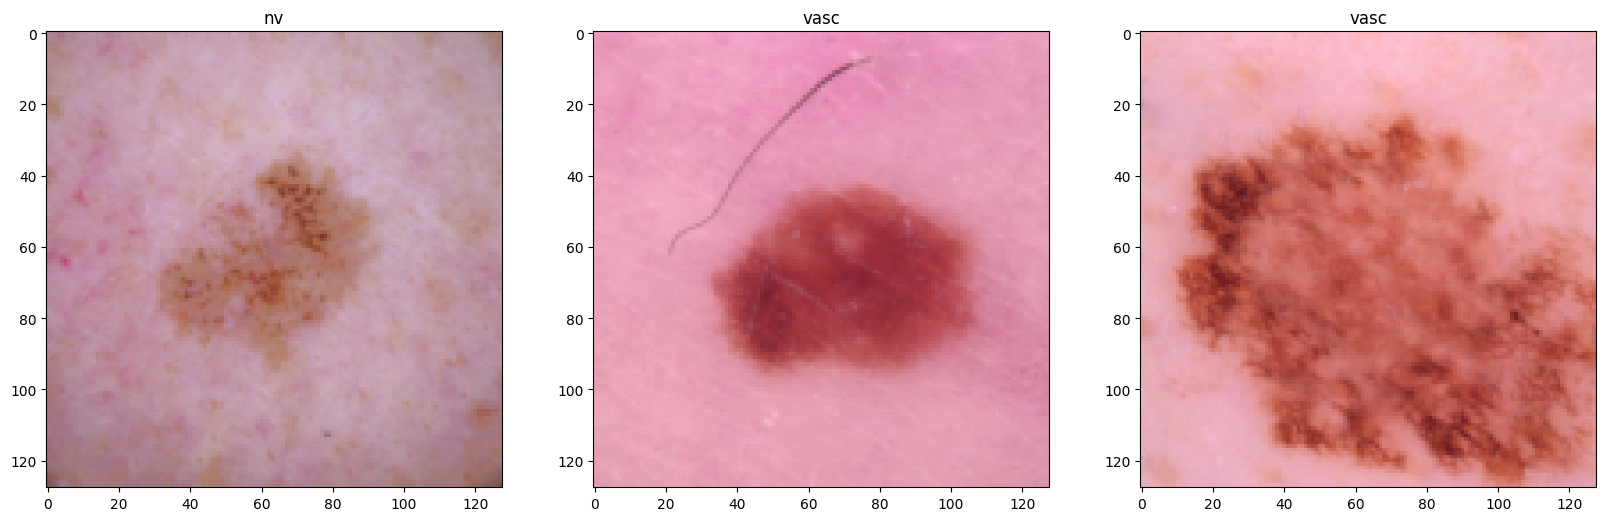

In [7]:
fig, axs = plt.subplots(1, 3)
fig.set_figheight(8)
fig.set_figwidth(20)
selected_indices = np.random.randint(0, high=len(train_images), size=3)
for i in range(0,3):
    axs[i].imshow(train_images[selected_indices[i]])
    axs[i].title.set_text(classDict[train_labels[selected_indices[i]].item()])

### Plot class distribution of your data.

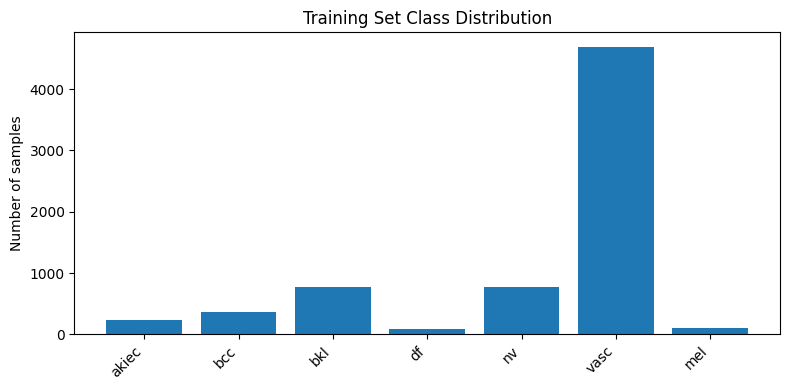

In [8]:
labels_flat = train_labels.flatten()
counts = Counter(labels_flat)

classes = sorted(counts.keys())
names = [classDict[c] for c in classes]
freqs = [counts[c] for c in classes]

plt.figure(figsize=(8,4))
plt.bar(names, freqs)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of samples")
plt.title("Training Set Class Distribution")
plt.tight_layout()
plt.show()

### Create Dataset Class

In [37]:
class DermoDataset(Dataset):
    def __init__(self, images, labels, classDict, input_size=(128,128), augmentation=False):
        super(DermoDataset, self).__init__()
        self.image_list = images
        self.label_list = labels
        self.augmentation = augmentation
        self.classDict = classDict
        self.height = input_size[0]
        self.width = input_size[1]

    def transform(self, img, label):
        transforms = [T.ToPILImage(), T.Resize((self.height, self.width)), ]
        if self.augmentation:
          transforms += [T.RandomHorizontalFlip(), T.RandomRotation(15), ]
        transforms += [T.ToTensor(), T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),]
        pipeline = T.Compose(transforms)
        img = pipeline(img)
        return img, label

    def __getitem__(self, index):
        img = self.image_list[index]
        label = int(self.label_list[index])

        img, label = self.transform(img, label)

        current_image = img
        current_label = label
        return current_image, current_label

    def __len__(self):
        return len(self.image_list)

In [38]:
train_dataset = DermoDataset(train_images, train_labels, classDict, input_size=(224,224), augmentation=True)
val_dataset = DermoDataset(val_images, val_labels, classDict,input_size=(224,224), augmentation=False)
print('Train set size:', len(train_dataset))
print('Val set size:', len(val_dataset))

Train set size: 7007
Val set size: 1003


### Create DataLoader
You should tune batch size

In [39]:
batch_size = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [40]:
dataloaders = {
    'train': train_loader,
    'val': val_loader
}

# Create Model

In [41]:
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64,128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128*16*16, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 7)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [52]:
class ResNet50Classifier(nn.Module):
    def __init__(
            self,
            ch,
            num_class,
            freeze
    ):
        super(ResNet50Classifier, self).__init__()
        self.model = models.resnet50(pretrained=True)
        if ch != 3:
          orig = self.model.conv1
          self.model.conv1 = nn.Conv2d(
              ch,
              orig.out_channels,
              kernel_size=orig.kernel_size,
              stride=orig.stride,
              padding=orig.padding,
              bias=False
          )
        if freeze:
          for param in self.model.parameters():
            param.requires_grad = False
        in_feats = self.model.fc.in_features
        self.model.fc = nn.Linear(in_feats, num_class)

    def forward(self, x):
        return self.model(x)

In [51]:
class Vit16Classifier(nn.Module):
    def __init__(
            self,
            ch,
            num_class,
            freeze
    ):
        super(Vit16Classifier, self).__init__()
        self.model = models.vit_b_16(pretrained=True)
        if ch != 3:
          orig = self.model.conv_proj
          self.model.conv_proj = nn.Conv2d(
              ch,
              orig.out_channels,
              kernel_size=orig.kernel_size,
              stride=orig.stride,
              padding=orig.padding,
              bias=(orig.bias is not None)
          )
        if freeze:
          for param in self.model.parameters():
            param.requires_grad = False

        in_feats = self.model.heads.head.in_features
        self.model.heads.head = nn.Linear(in_feats, num_class)

    def forward(self, x):
        return self.model(x)

In [53]:
model = SimpleCNN()
model.to(device="cuda:0")

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=7, bias=True)
)

In [54]:
model = ResNet50Classifier(3, 7, False)
model.to(device="cuda:0")

ResNet50Classifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [55]:
model = Vit16Classifier(3, 7, False)
model.to(device="cuda:0")

Vit16Classifier(
  (model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1):

# Training

### Set Optimizer with parameters

In [56]:
lrRate = 1e-4
weightDecay = 1e-5
numberOfEpoch = 20
early_stop = 5
device = "cuda:0"
dtype = torch.cuda.FloatTensor
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lrRate, weight_decay=weightDecay)






### Loss Function

In [57]:
class_weights = torch.tensor([1.0/counts[i] for i in sorted(counts.keys())], device=device)
calc_loss = nn.CrossEntropyLoss(weight=class_weights)

### Train Loop

In [62]:
def train(model, dataloaders, calc_loss, optimizer, numberOfEpoch, early_stop, device, dtype):
    best_model = copy.deepcopy(model.state_dict())
    best_loss = 1e7
    early_stop_counter = 0
    train_loss_list = []
    val_loss_list = []

    total_memory = f'{torch.cuda.get_device_properties(0).total_memory/ 1E9 if torch.cuda.is_available() else 0:.3g}G'
    for epoch in range(0, numberOfEpoch):
        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            epoch_loss = 0.0
            correct_prediction = 0.0
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode
            batch_step = 0
            batch_size = dataloaders[phase].batch_size
            with tqdm(dataloaders[phase], unit="batch") as tbar:
                for input_imgs, gt_labels in tbar:
                    tbar.set_description(f"Epoch {epoch}")
                    batch_step += 1
                    input_imgs = input_imgs.to(device).type(dtype)
                    gt_labels = gt_labels.to(device).type(dtype)

                    optimizer.zero_grad()
                    outputs = model(input_imgs)
                    loss = calc_loss(outputs, gt_labels.long())
                    if phase == 'train':
                      loss.backward()
                      optimizer.step()
                    epoch_loss += loss.item() * input_imgs.size(0)
                    _, preds = torch.max(outputs, 1)
                    correct_prediction += torch.sum(preds == gt_labels).item()
                    tbar.set_postfix(loss=loss.item(), acc=correct_prediction/((batch_step)*batch_size))

            epoch_loss = epoch_loss / len(dataloaders[phase].dataset)
            if phase=='train':
              train_loss_list.append(epoch_loss)
            else:
              val_loss_list.append(epoch_loss)

            if phase=='val':
              if epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model = copy.deepcopy(model.state_dict())
                early_stop_counter = 0
              else:
                early_stop_counter += 1
        if early_stop_counter >= early_stop:
          print(f"Stopping early at epoch {epoch}")
          break

    model.load_state_dict(best_model)
    return best_model, train_loss_list, val_loss_list

In [63]:
best_model, train_loss_list, val_loss_list = train(model, dataloaders, calc_loss, optimizer, 5, early_stop, device, dtype)

  0%|          | 0/1752 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-37-1a88539f4134>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.label_list[index])
<ipython-input-37-1a88539f4134>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before pe

### Visualization
plot training and validation loss

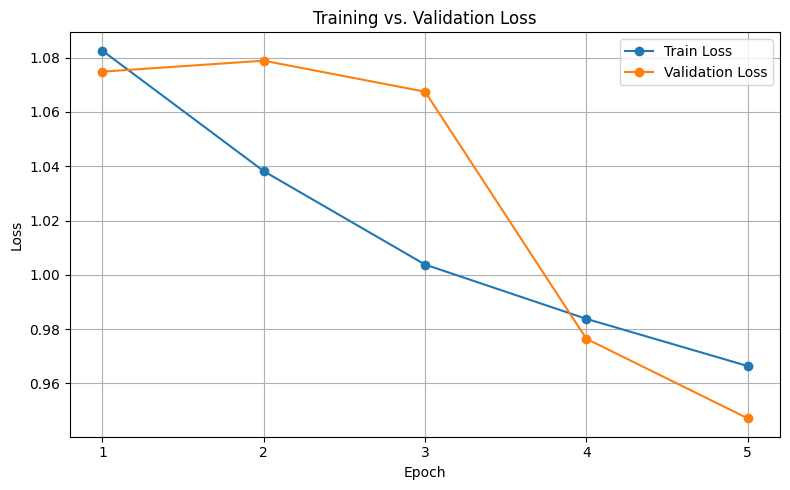

In [64]:
epochs = range(1, len(train_loss_list) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss_list, marker='o', label='Train Loss')
plt.plot(epochs, val_loss_list,   marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Test

In [69]:
model = Vit16Classifier(3, 7, False)
model.load_state_dict(best_model)
model.to(device)
model.eval()

test_ds = DermoDataset(test_images, test_labels, classDict, input_size=(224,224), augmentation=False)

correct = 0
confusion_matrix = torch.zeros(7, 7, dtype=torch.int64, device=device)

for i in range(len(test_images)):
  current_test_img = test_images[i]
  img = T.ToPILImage()(current_test_img)
  img = T.Resize((224, 224))(img)
  img = T.ToTensor()(img)
  img = T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])(img)
  img = img.unsqueeze(0).to(device)

  with torch.no_grad():
    outputs = model(img)
  _, pred = torch.max(outputs, 1)

  gt = int(test_labels[i].item())
  correct += (pred.item() == gt)
  confusion_matrix[gt, pred.item()] += 1

### Evaluation Metrics ###
Overall accuracy, confusion matrix, and precision, recall, f1 score for each class.

In [75]:
total = len(test_labels)
accuracy = correct / total
print(f"Overall test accuracy: {accuracy:.4f}\n")

precision = torch.zeros(7, device=device)
recall    = torch.zeros(7, device=device)
f1_score  = torch.zeros(7, device=device)

for cls in range(7):
  tp = confusion_matrix[cls, cls].item()
  fp = confusion_matrix[:, cls].sum().item() - tp
  fn = confusion_matrix[cls, :].sum().item() - tp
  precision[cls] = tp / (tp + fp) if (tp + fp) > 0 else 0.0
  recall[cls]    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
  if precision[cls] + recall[cls] > 0:
    f1_score[cls] = 2 * precision[cls] * recall[cls] / (precision[cls] + recall[cls])

for idx, name in classDict.items():
  print(f"{name:>5} |  P: {precision[idx]:.3f}  R: {recall[idx]:.3f}  F1: {f1_score[idx]:.3f}")

print("\nConfusion Matrix:\n", confusion_matrix.cpu().numpy())

Overall test accuracy: 0.7187

akiec |  P: 0.308  R: 0.500  F1: 0.382
  bcc |  P: 0.442  R: 0.660  F1: 0.529
  bkl |  P: 0.433  R: 0.627  F1: 0.512
   df |  P: 0.357  R: 0.217  F1: 0.270
   nv |  P: 0.467  R: 0.543  F1: 0.502
 vasc |  P: 0.935  R: 0.787  F1: 0.855
  mel |  P: 0.875  R: 0.724  F1: 0.792

Confusion Matrix:
 [[  33   19   11    0    2    1    0]
 [   9   68   12    1    7    5    1]
 [  19   14  138    0   35   14    0]
 [   5    8    4    5    0    1    0]
 [  14    5   29    3  121   50    1]
 [  27   37  125    4   92 1055    1]
 [   0    3    0    1    2    2   21]]
